In [1]:
using LinearAlgebra
using Distributions
using Optim
using Random
using StatsFuns
using JuMP
using MosekTools
using StatsBase
using SparseArrays # 可选，用于处理稀疏性（如果数据量很大）
using FileIO
using JLD2
using Plots
using LaTeXStrings
using DataFrames, Colors
using StatsPlots   # 提供 boxplot，基于 Plots

include("Params_PP.jl")
include("Data_Generation_PP.jl")
include("Estimation_PP.jl")
include("Evaluation_PP.jl")
# # include("Plot_Figures.jl")
include("Implement_All_Methods_PP.jl")
include("Models_PP.jl")

Solve_RO (generic function with 1 method)

## Functions

In [2]:
function Generate_Input_this(S_train, N, N_u, K, offdiag_sign,max_offdiag,P_bar,is_original_setting,lambda)
    Input_Data_this = Dict()
    A_true, B_true = Generate_Coef(N_u, N, max_offdiag, offdiag_sign,is_original_setting);
    P_train,PM_train,choice_train,PM_train_extend = Generate_Data(N,S_train,A_true,B_true,P_bar);

    Input_Data_this["A_true"] = A_true;
    Input_Data_this["B_true"] = B_true;
    Input_Data_this["P_dag"] = round.(rand(N, K) .* P_bar; digits=2);
    Input_Data_this["P_train"] = P_train;
    Input_Data_this["PM_train_extend"] = PM_train_extend;
    Input_Data_this["choice_train"] = choice_train;

    # A_hat,B_hat = Estimate_MNL_Para(PM_train_extend, P_train, choice_train,S_train, N);

    # A_hat,B_hat = Estimate_MNL_Para_Ridge(PM_train_extend, P_train, choice_train,S_train, N, lambda);
    A_hat,B_hat,Intercept,obj_val,sol_status,solve_time = Estimate_OPT_Model(N,N_u*N,S_train,PM_train,P_train,choice_train,false,0.0001)
    A_hat = hcat(A_hat, reshape(Intercept, :,1))

    Input_Data_this["A_hat"] = A_hat
    Input_Data_this["B_hat"] = B_hat
    return Input_Data_this
end

Generate_Input_this (generic function with 1 method)

In [3]:
function Get_Input_Data(Input_Data_this)
    A_true = Input_Data_this["A_true"]
    B_true = Input_Data_this["B_true"]
    P_dag = Input_Data_this["P_dag"]
    P_train = Input_Data_this["P_train"]
    PM_train_extend = Input_Data_this["PM_train_extend"]
    choice_train = Input_Data_this["choice_train"]
    A_hat = Input_Data_this["A_hat"]
    B_hat = Input_Data_this["B_hat"]
    return A_true,B_true,P_dag,P_train,PM_train_extend,choice_train,A_hat,B_hat
end

Get_Input_Data (generic function with 1 method)

In [4]:
function solve_ETO_this(N,N_u,K,A,B,A_true, B_true,P_dag,Time_Limit)
    RST_this = Dict()
    status_this = "NotDefined"
    obj_,X_,Promo_, time_,status_ = Solve_ETO(N,N_u,K,A, B,P_dag,Time_Limit)
    if status_ != "OPTIMAL"
        status_this = status_
    else
        status_this = status_
        rev_, price_ = compute_oof(X_, A_true, B_true, vcat(Promo_,1), P_dag)
        RST_this["obj"] = obj_
        RST_this["price"] = price_
        RST_this["promo"] = Promo_
        RST_this["time"] = time_
        RST_this["Rev"] = rev_
        RST_this["status"] = status_
    end
    return RST_this,status_this
end

solve_ETO_this (generic function with 1 method)

In [5]:
function solve_RO_this(N,N_u,K,A_hat,B_hat,A_true, B_true,P_dag,psi_lb,psi_ub,phi_lb,phi_ub,gamma_list,dual_norm,Time_Limit)
    RST_this = Dict()
    status_this = "NotDefined"
    for gamma in gamma_list
        obj_RO,X_RO,Promo_RO, time_RO,status_RO = Solve_RO(N,N_u,K,A_hat,B_hat,P_dag,psi_lb,psi_ub,phi_lb,phi_ub,gamma * ones(N),dual_norm,Time_Limit)
        println("gamma=$(gamma),status:",status_RO,",time=$time_RO")
        if status_RO != "OPTIMAL"
            status_this = status_RO
            break
        else
            status_this = status_RO
            rev_RO, price_RO = compute_oof(X_RO, A_true, B_true, vcat(Promo_RO,1), P_dag)
            RST_this["obj_gamma=$(gamma)"] = obj_RO
            RST_this["price_gamma=$(gamma)"] = price_RO
            RST_this["promo_gamma=$(gamma)"] = Promo_RO
            RST_this["time_gamma=$(gamma)"] = time_RO
            RST_this["Rev_gamma=$(gamma)"] = rev_RO
            RST_this["status"] = status_this
        end
    end
    return RST_this,status_this
end

solve_RO_this (generic function with 1 method)

#### Parameters

In [6]:
Params = get_default_params_PP()
seed = Params["seed"]
N = Params["N"]
N_u = Params["N_u"] 
K = Params["K"] 
S_train = Params["S_train"]
S_test = Params["S_test"]
P_bar = Params["P_bar"]
iterations = Params["iterations"]
offdiag_sign = Params["offdiag_sign"]
max_offdiag = Params["max_offdiag"]
Time_Limit = Params["Time_Limit"]
gamma_list = Params["gamma_list"]
dual_norm = Params["dual_norm"]
psi_lb = Params["psi_lb"]
psi_ub = Params["psi_ub"]
phi_lb = Params["phi_lb"]
phi_ub = Params["phi_ub"]

3-element Vector{Float64}:
 0.0
 0.0
 0.0

In [7]:
is_original_setting = true
Random.seed!(seed)

project_dir = "Joint_Pricing_and_Promotion/"
current_dir = pwd()
parent_dir = dirname(current_dir)
grand_pa_dir = dirname(parent_dir)
data_dir = string(dirname(grand_pa_dir), "/Data/")
if !isdir(data_dir)
    mkpath(data_dir)
end
if is_original_setting
    sub_file_name = "MS_2024_N=$(N)_N_u=$(N_u)_K=$(K)_S_train=$(S_train)_seed=$(seed)_ECP_Estimation/"
else
    sub_file_name = "N=$(N)_N_u=$(N_u)_K=$(K)_S_train=$(S_train)_offdiag_sign=$(offdiag_sign)_max_offdiag=$(max_offdiag)_seed=$(seed)_Ridge/"
end
this_data_file = string(data_dir,project_dir,sub_file_name)
if !isdir(this_data_file)
    mkpath(this_data_file)
end
println(this_data_file)
save(string(this_data_file, "Params.jld2"), Params);

/Users/zhangxun/Dropbox/Research/Robust_Exp/Data/Joint_Pricing_and_Promotion/MS_2024_N=3_N_u=1_K=30_S_train=100_seed=3_ECP_Estimation/


In [8]:
lambda = 0.1
Result_All = Dict()
iter = 1
while iter <= iterations
    t_start = time()  # 记录开始时间
    Input_Data_this = Generate_Input_this(S_train, N, N_u, K, offdiag_sign,max_offdiag,P_bar,is_original_setting,lambda)
    A_true,B_true,P_dag,P_train,PM_train_extend,choice_train,A_hat,B_hat = Get_Input_Data(Input_Data_this)
    if any(isnan, A_hat) || any(isnan, B_hat) || norm([vec(A_true .- A_hat);vec(B_true .- B_hat)],2) >= 10
        println("Estimate contains NaN values")
        continue
    end
    Result_All["Input_Data_iter=$(iter)"] = Input_Data_this

    RST_Oracle,status_Oracle = solve_ETO_this(N,N_u,K,A_true,B_true,A_true, B_true,P_dag,Time_Limit)
    println("Oracle: status = ",status_Oracle,",time=",RST_Oracle["time"])
    if status_Oracle != "OPTIMAL"
        println("Oracle did not approach the optimal solution")
        continue
    end
    Result_All["RST_Oracle_iter=$(iter)"] = RST_Oracle

    RST_ETO,status_ETO = solve_ETO_this(N,N_u,K,A_hat,B_hat,A_true, B_true,P_dag,Time_Limit)
    println("ETO: status = ",status_ETO,",time=",RST_ETO["time"])
    if status_ETO != "OPTIMAL"
        println("ETO did not approach the optimal solution")
        continue
    end
    Result_All["RST_ETO_iter=$(iter)"] = RST_ETO
    
    obj_RO,X_RO,Promo_RO, time_RO,status_RO = Solve_RO(N,N_u,K,A_hat,B_hat,P_dag,psi_lb,psi_ub,phi_lb,phi_ub,0.0 * ones(N),dual_norm,Time_Limit)
    if status_RO != "OPTIMAL"
        println("RO did not approach the optimal solution")
        continue
    end
    rev_RO, price_RO = compute_oof(X_RO, A_true, B_true, vcat(Promo_RO,1), P_dag)
    if abs(rev_RO - RST_ETO["Rev"]) >= 0.001
        println("ETO rev is not equivalent to RO rev")
        continue
    end

    RST_RO,status_RO = solve_RO_this(N,N_u,K,A_hat,B_hat,A_true, B_true,P_dag,psi_lb,psi_ub,phi_lb,phi_ub,gamma_list,dual_norm,Time_Limit)
    # println("RO status = ",status_RO)
    if status_RO != "OPTIMAL"
        println("RO did not approach the optimal solution")
        continue
    end
    Result_All["RST_RO_iter=$(iter)"] = RST_RO
    save(string(this_data_file, "Result_All.jld2"), Result_All);
    t_end = time()  # 记录结束时间
    println("******* Time for iter $iter: ", round(t_end - t_start, digits=2), " seconds *********")
    iter = iter + 1
end
save(string(this_data_file, "Result_All_lambda=$(lambda).jld2"), Result_All);

Oracle: status = OPTIMAL,time=2.652582883834839
ETO: status = OPTIMAL,time=4.379035949707031
gamma=0.0,status:OPTIMAL,time=48.02419996261597
gamma=0.005,status:OPTIMAL,time=42.240352153778076
gamma=0.01,status:OPTIMAL,time=36.7528030872345
gamma=0.015,status:OPTIMAL,time=56.40366888046265
gamma=0.02,status:OPTIMAL,time=47.88881015777588
gamma=0.03,status:OPTIMAL,time=42.70000886917114
gamma=0.04,status:OPTIMAL,time=35.63337707519531
gamma=0.06,status:OPTIMAL,time=28.413650035858154
gamma=0.08,status:OPTIMAL,time=29.64417290687561
******* Time for iter 1: 435.32 seconds *********
Oracle: status = OPTIMAL,time=1.3993899822235107
ETO: status = OPTIMAL,time=9.620612859725952
ETO rev is not equivalent to RO rev
Estimate contains NaN values
Oracle: status = OPTIMAL,time=3.720992088317871
ETO: status = OPTIMAL,time=6.827455997467041
ETO rev is not equivalent to RO rev
Oracle: status = OPTIMAL,time=2.8982789516448975
ETO: status = OPTIMAL,time=1.7770850658416748
gamma=0.0,status:OPTIMAL,time=8

In [9]:
Result_All = load(string(this_data_file, "Result_All_lambda=$(lambda).jld2"));

In [10]:
iter = 1
RST_RO_iter = Result_All["RST_RO_iter=$(iter)"]
gamma_list = sort([parse(Float64, split(k, "=")[end]) for k in keys(RST_RO_iter) if startswith(k, "Rev_gamma=")])
println("Gamma list: ", gamma_list)

Gamma list: [0.0, 0.005, 0.01, 0.015, 0.02, 0.03, 0.04, 0.06, 0.08]


In [11]:
Rev_Oracle = [Result_All["RST_Oracle_iter=$(iter)"]["Rev"] for iter in 1:iterations]
Rev_ETO = [Result_All["RST_ETO_iter=$(iter)"]["Rev"] for iter in 1:iterations]
Rev_RO = zeros(iterations,length(gamma_list))
for iter in 1:iterations
    RST_RO = Result_All["RST_RO_iter=$(iter)"]
    for g_index in 1:length(gamma_list)
        gamma = gamma_list[g_index]
        Rev_RO[iter,g_index] = RST_RO["Rev_gamma=$(gamma)"]
    end
end
println("Rev_ETO/Rev_Oracle = ",round.(Rev_ETO./Rev_Oracle,digits=4))
println("Rev_RO/Rev_Oracle = ",round.(Rev_RO[:,1]./Rev_Oracle,digits=4))
println("Rev_ETO/Rev_Oracle = ",mean(Rev_ETO)/mean(Rev_Oracle))

Rev_ETO/Rev_Oracle = [0.9832, 0.7829, 0.9615, 0.945, 0.6559, 0.791, 0.9813, 0.957, 0.9504, 0.9775, 0.6277, 0.7124, 0.7669, 0.8233, 0.9843, 0.9977, 0.7025, 0.561, 0.9892, 0.9744, 0.994, 0.8481, 0.9265, 0.989, 0.8222, 0.986, 0.9632, 0.9485, 0.7273, 0.9489, 0.9652, 0.9666, 0.961, 0.9571, 0.8739, 0.9381, 0.9826, 0.9473, 0.9669, 0.8677, 0.9376, 0.9862, 0.651, 0.895, 0.9661, 0.9364, 0.9272, 0.8382, 0.9407, 0.947, 0.8564, 0.9409, 0.8623, 0.6366, 0.9873, 0.7777, 0.9497, 0.5003, 0.7674, 0.9288, 0.7899, 0.9626, 0.9638, 0.9077, 0.9515, 0.9568, 0.8494, 0.9139, 0.9662, 0.782, 0.9505, 0.4483, 0.8375, 0.9223, 0.8076, 0.9729, 0.9846, 0.9692, 0.9391, 0.9625, 0.9371, 0.9293, 0.8691, 0.9838, 0.8884, 0.8855, 0.9502, 0.9575, 0.8643, 0.7472, 0.573, 0.8289, 0.9101, 0.9668, 0.8171, 0.9461, 0.9253, 0.482, 0.91, 0.9593]
Rev_RO/Rev_Oracle = [0.9832, 0.7829, 0.9615, 0.945, 0.6559, 0.791, 0.9813, 0.957, 0.9504, 0.9775, 0.6277, 0.7124, 0.7669, 0.8233, 0.9843, 0.9977, 0.7025, 0.561, 0.9892, 0.9744, 0.994, 0.8481, 0.

In [12]:
RO_ETO_Ratio_Mean = zeros(length(gamma_list))
RO_ETO_Ratio_Std = zeros(length(gamma_list))
for g_index in 1:length(gamma_list)
    gamma = gamma_list[g_index]
    RO_ETO_Ratio_Mean[g_index] = mean(Rev_RO[:,g_index])/mean(Rev_ETO)
    RO_ETO_Ratio_Std[g_index] = std(Rev_RO[:,g_index])/std(Rev_ETO)
    println("gamma=$gamma,Mean =",RO_ETO_Ratio_Mean[g_index],", Std =",RO_ETO_Ratio_Std[g_index])
end

gamma=0.0,Mean =1.00000016133686, Std =0.9999813063543568
gamma=0.005,Mean =1.009360401047258, Std =0.9555661906788648
gamma=0.01,Mean =1.0097151756060838, Std =0.9296232473864151
gamma=0.015,Mean =1.010680591560742, Std =0.9256537438007755
gamma=0.02,Mean =0.9951799405505491, Std =0.9812455029576549
gamma=0.03,Mean =0.9678259360337788, Std =0.9672816097631312
gamma=0.04,Mean =0.921202546143789, Std =0.9709666732169288
gamma=0.06,Mean =0.8339865978139412, Std =1.0070154249620402
gamma=0.08,Mean =0.7605840224422562, Std =0.972465188340405


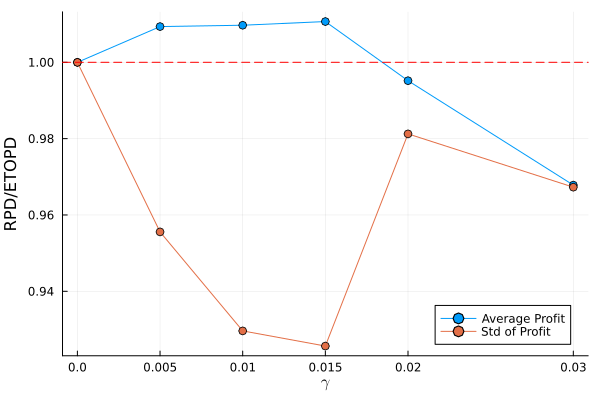

"/Users/zhangxun/Dropbox/Research/Robust_Exp/Data/Joint_Pricing_and_Promotion/MS_2024_N=3_N_u=1_K=30_S_train=100_seed=3_ECP_Estimation/RPP_vs_ETOPP.pdf"

In [13]:
end_index = length(gamma_list) - 3
plot(gamma_list[1:end_index], RO_ETO_Ratio_Mean[1:end_index], marker=:o, xlabel=L"\gamma", label="Average Profit", xticks=(gamma_list[1:end_index], string.(gamma_list[1:end_index])))
plot!(gamma_list[1:end_index], RO_ETO_Ratio_Std[1:end_index], marker=:o, xlabel=L"\gamma", ylabel="RPD/ETOPD", label="Std of Profit")
hline!([1.0], linestyle=:dash, color=:red, label="")
display(current())
savefig(string(this_data_file, "RPP_vs_ETOPP.pdf"))

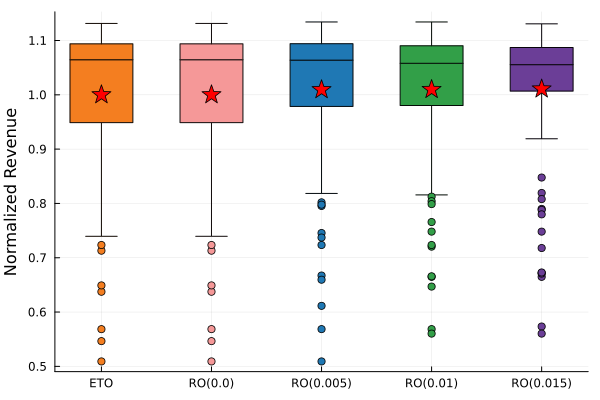

"/Users/zhangxun/Dropbox/Research/Robust_Exp/Data/Joint_Pricing_and_Promotion/MS_2024_N=3_N_u=1_K=30_S_train=100_seed=3_ECP_Estimation/RPP_vs_ETOPP_BoxPlot.pdf"

In [14]:
chosen_indices = [1,2,3,4]
gamma_chosen = gamma_list[chosen_indices]
data = [Rev_ETO./mean(Rev_ETO), [Rev_RO[:,ind]./mean(Rev_ETO) for ind in chosen_indices]...]
labels = ["ETO"; ["RO($gamma)" for gamma in gamma_chosen]]
# --- 1) 展开成长表 ---
df = DataFrame(
    value = vcat(data...),
    group = repeat(labels, inner = length(data[1]))
)

mycolors = palette(:tab10)[1:length(labels)]   # tab10 最多10个颜色
mycolors = ["#f47e20","#f59898","#1f78b4","#329f48","#6b3e97","#d2ab82","#f47e20"]
# --- 3) 绘制箱线图 ---
@df df boxplot(:group, :value;
    group = :group,
    palette = mycolors,
    legend = false,
    ylabel = "Normalized Revenue",
    # title = "Revenue Distribution"
)

# --- 4) 计算均值 ---
means = combine(groupby(df, :group), :value => mean => :mean_val)

for i in 1:length(labels)
    scatter!([labels[i]], [means.mean_val[i]];
        color = :red,
        marker = (:star, 10),
        label = "")
end

# # # --- 6) 绘制均值连线（这里必须把类别转为数值 1:N） ---
# plot!(labels, means.mean_val;
#     seriestype = :line,
#     color = :red,
#     lw = 2,
#     ls = :dash,
#     label = "Mean trend"
# )
display(current())
savefig(string(this_data_file, "RPP_vs_ETOPP_BoxPlot.pdf"))

In [15]:
# bad_idx = findall(i -> abs(Rev_ETO[i] - Rev_RO[i,1]) > 0.01, 1:length(Rev_ETO));
# keep_idx = setdiff(1:length(Rev_ETO), bad_idx);
# Rev_ETO_clean = Rev_ETO[keep_idx];
# Rev_Oracle_clean = Rev_Oracle[keep_idx];
# Rev_RO_clean = Rev_RO[keep_idx, :];
# RO_ETO_Ratio_Mean = zeros(length(gamma_list))
# RO_ETO_Ratio_Std = zeros(length(gamma_list))
# for g_index in 1:length(gamma_list)
#     gamma = gamma_list[g_index]
#     RO_ETO_Ratio_Mean[g_index] = mean(Rev_RO_clean[:,g_index])/mean(Rev_ETO_clean)
#     RO_ETO_Ratio_Std[g_index] = std(Rev_RO_clean[:,g_index])/std(Rev_ETO_clean)
#     println("gamma=$gamma,Mean =",RO_ETO_Ratio_Mean[g_index],", Std =",RO_ETO_Ratio_Std[g_index])
# end
# println("Rev_ETO/Rev_Oracle = ",mean(Rev_ETO_clean)/mean(Rev_Oracle_clean))

In [16]:
# end_index = length(gamma_list) -1
# plot(gamma_list[1:end_index], RO_ETO_Ratio_Mean[1:end_index], marker=:o, xlabel=L"\gamma", label="Average Profit", xticks=(gamma_list[1:end_index], string.(gamma_list[1:end_index])))
# plot!(gamma_list[1:end_index], RO_ETO_Ratio_Std[1:end_index], marker=:o, xlabel=L"\gamma", ylabel="RPD/ETOPD", label="Std of Profit")
# hline!([1.0], linestyle=:dash, color=:red, label="")
# display(current())
# savefig(string(this_data_file, "RPP_vs_ETOPP_Clean.pdf"))